<a href="https://colab.research.google.com/github/ajayrfhp/LearningDeepLearning/blob/main/GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implement GPT architecture to generate text

- GPT has a lot of repetable components

In [1]:
import torch
import  torch.nn as nn

In [24]:
# get number of parameters in transformer block
def count_parameters_millions(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / (1e6)

### GPT architecture

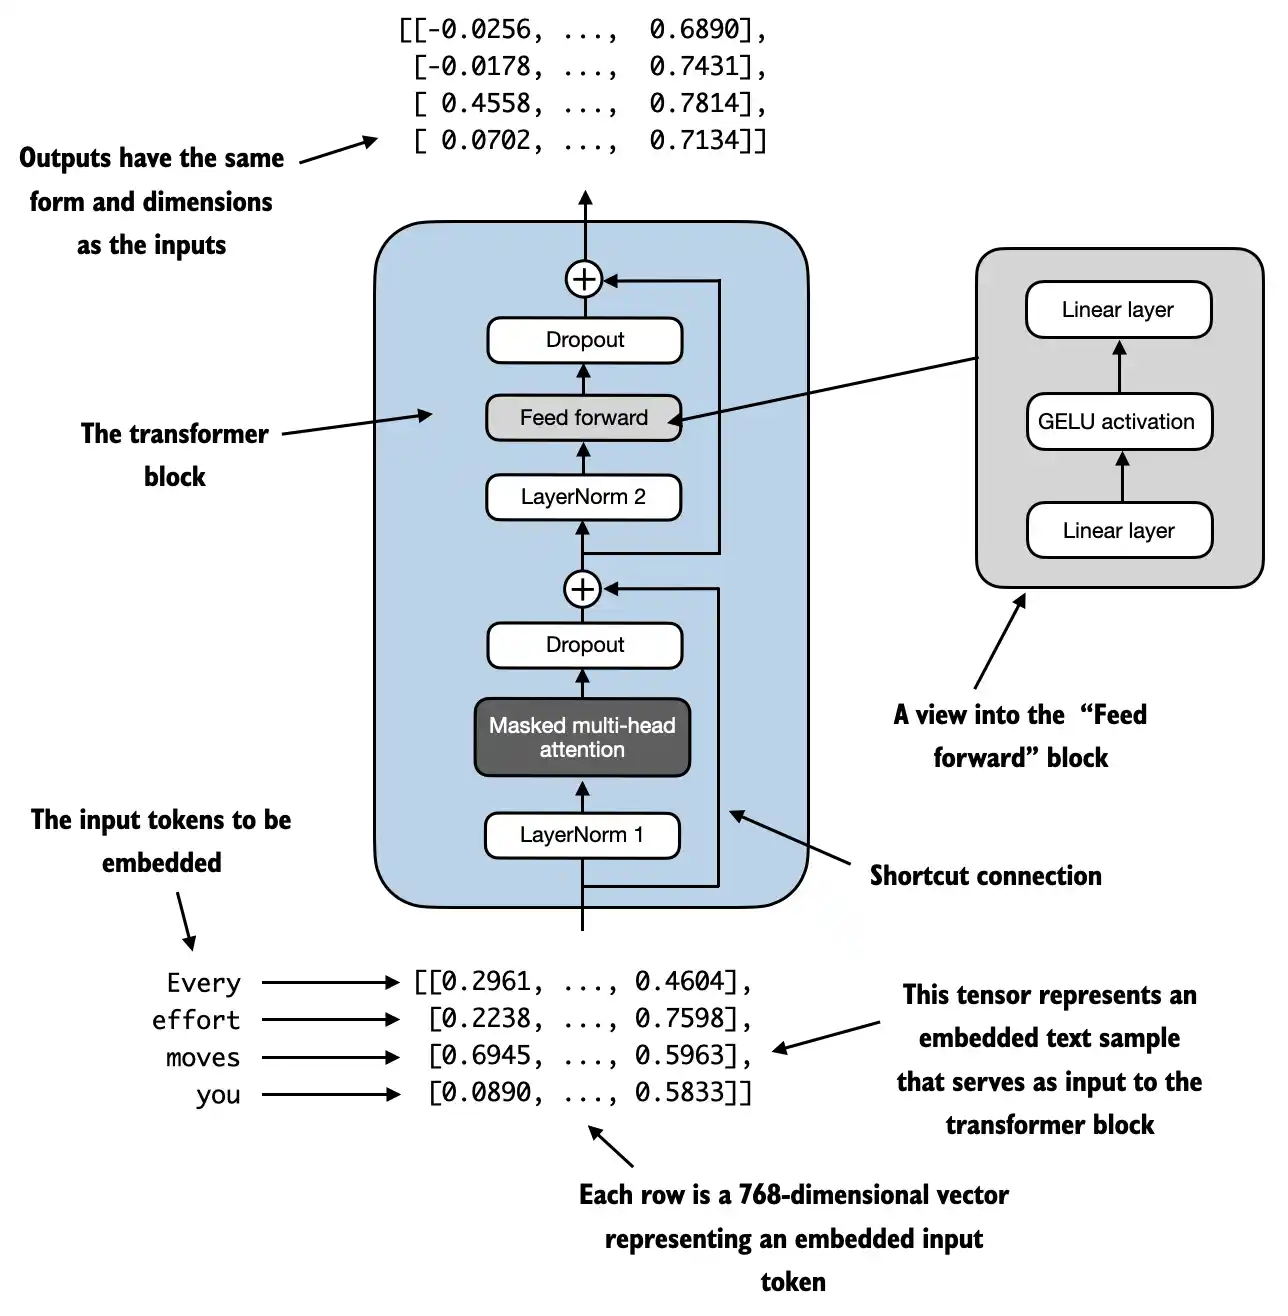

In [2]:

GPT_2_SMALL_CONFIG = {
    "vocab_size": 50257,
    "context_length" : 1024,
    "emb_dim" : 768,
    "n_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.1
}


### Multi head attention was implemented and broken apart [here](https://colab.research.google.com/drive/1Ne0izBxqSDAWsCChaTOYMHZApTTxE5mX#scrollTo=W3WWJgjvburh)

In [52]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        d_in = config["emb_dim"]
        d_out = int(config["emb_dim"] / config["n_heads"])
        heads = config["n_heads"]
        self.heads = heads
        self.d_out = d_out
        self.d_in = d_in

        # Define nn.Linear layers for Q, K, and V
        self.W_Q = nn.Linear(d_in, d_out * heads, bias = False)  # (d_in, d_out * heads)
        self.W_K = nn.Linear(d_in, d_out * heads, bias = False)  # (d_in, d_out * heads)
        self.W_V = nn.Linear(d_in, d_out * heads, bias = False)  # (d_in, d_out * heads)

        self.out_project = nn.Linear(d_out * heads, d_out * heads)

    def forward(self, x):

        # shape of input is (BS, T, d_in)

        token_length = x.shape[1]

        # Calculate Q, K, and V using nn.Linear layers
        Q = self.W_Q(x)  # (BS, T, d_out * heads)
        Q = Q.view(x.shape[0], token_length, self.heads, self.d_out)  # (BS, T, heads, d_out)
        Q = Q.permute(0, 2, 1, 3)  # (BS, heads, T, d_out)

        K = self.W_K(x)  # (BS, T, d_out * heads)
        K = K.view(x.shape[0], token_length, self.heads, self.d_out)  # (BS, T, heads, d_out)
        K = K.permute(0, 2, 1, 3)  # (BS, heads, T, d_out)

        V = self.W_V(x)  # (BS, T, d_out * heads)
        V = V.view(x.shape[0], token_length, self.heads, self.d_out)  # (BS, T, heads, d_out)
        V = V.permute(0, 2, 1, 3)  # (BS, heads, T, d_out)

        # Calculate attention scores
        self_attention_scores = torch.matmul(Q, K.transpose(-1, -2))  # (BS, heads, T, T)
        self_attention_scores = self_attention_scores / torch.sqrt(torch.tensor(self.d_out))  # (BS, heads, T, T)

        # Apply causal attention mask
        mask = torch.triu(torch.ones_like(self_attention_scores, dtype=bool), diagonal=1)  # (BS, heads, T, T)
        self_attention_scores = torch.where(mask, -float('inf'), self_attention_scores)  # (BS, heads, T, T)

        self_attention_matrix = torch.softmax(self_attention_scores, dim=-1)  # (BS, heads, T, T)


        assert(torch.allclose(self_attention_matrix.sum(dim=-1), torch.ones_like(self_attention_matrix.sum(dim=-1))))
        assert(torch.allclose(self_attention_matrix, torch.tril(self_attention_matrix, diagonal=1)))

        XV = torch.matmul(self_attention_matrix, V).transpose(1, 2).reshape((x.shape[0], token_length, -1))  # (BS, T, heads, d_out)

        o = self.out_project(XV)  # (BS, T, d_out)

        return o

In [53]:
mha = MultiHeadAttention(GPT_2_SMALL_CONFIG)
mha(torch.randn(2, 3, 768)).shape

count_parameters_millions(mha)

2.360064

In [49]:
# list number of parameters for each layer by name

sum_params = 0
for name, param in mha.named_parameters():
    print(name, param.numel())
    sum_params += param.numel()

print(f"Total number of parameters: {sum_params}")

W_Q.weight 589824
W_K.weight 589824
W_V.weight 589824
out_project.weight 49152
out_project.bias 64
Total number of parameters: 1818688


### Layer Norm

- Normalizes along last dimension, sets mean of output to 0 and scale to 1
- Scale and bias are configurable, but are left as 0, 1

In [40]:
class LayerNorm(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.scale = nn.Parameter(torch.ones(config["emb_dim"]))
        self.bias = nn.Parameter(torch.zeros(config["emb_dim"]))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return (x - mean) * self.scale / std + self.bias

In [42]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.feed_forward = nn.Sequential(
            nn.Linear(config["emb_dim"], 4 * config["emb_dim"]),
            nn.GELU(),
            nn.Linear(4 * config["emb_dim"], config["emb_dim"])
        )

    def forward(self, x):
      return self.feed_forward(x)

feed_forward = FeedForward(GPT_2_SMALL_CONFIG)

count_parameters_millions(feed_forward)

4.722432

In [43]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.layer_norm1 = LayerNorm(config)
        self.layer_norm2 = LayerNorm(config)
        self.self_attention_block = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)


    def forward(self, x):
        x_skip = x
        x = self.layer_norm1(x)
        x = self.transformer_blocks(x)
        x = nn.Dropout(self.config["drop_rate"])(x)
        x = x + x_skip

        x_skip = x
        x = self.layer_norm2(x)
        x = self.feed_forward(x)
        x = nn.Dropout(self.config["drop_rate"])(x)

        x = x + x_skip


        return x

transformer_block = TransformerBlock(GPT_2_SMALL_CONFIG)
count_parameters_millions(transformer_block)


6.544192

In [36]:
GPT_2_SMALL_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1}

In [46]:
class GPT(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    # token embedding
    self.token_embedding = nn.Embedding(config["vocab_size"], config["emb_dim"])

    # position embedding
    self.position_embedding = nn.Embedding(config["context_length"], config["emb_dim"])

    self.transformer_blocks = nn.Sequential(
        *[TransformerBlock(config) for _ in range(config["n_layers"])]
    )

    self.output_projection = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)

  def forward(self, x):
    token_embeddings = self.token_embedding(x)
    position_embeddings = self.position_embedding(torch.arange(x.shape[1]))
    x = token_embeddings + position_embeddings

    x = self.transformer_blocks(x)

    x = self.output_projection(x)

    return x


gpt = GPT(GPT_2_SMALL_CONFIG)
count_parameters_millions(gpt)

156.511488